## Selecting data

We'll drop schools that aren't coed. We'll also drop schools that are for-profit. For features, we'll drop non-numeric features as well as features that are mostly missing data. We'll impute missing values with a simple feature mean.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

df = pd.read_csv('data/joined.csv', index_col = 'SchoolId')
df = df.drop(df[df['Coeducational'] != 'Yes'].index)
df = df.drop(df[df['Institution Type'] == 'Private for-profit'].index)
df = df.select_dtypes('float')
mask = df.isna().sum() / len(df) > 0.7
df = df.drop(columns = df.columns[mask])
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1660 entries, 659 to 3378
Columns: 137 entries, 2016 Graduates Who Took Out Loans to Yield Rate (women)
dtypes: float64(137)
memory usage: 1.7 MB


---
## Predicting Yield Rate with regression models

We'll predict the overall `Yield Rate (all)` using the other numeric features of the dataset. We'll drop the likely highly correlated `Yield Rate (men)` and `Yield Rate (women)` along with the target `Yield Rate (all)` from the predictor features:

In [2]:
y = df['Yield Rate (women)']

drop_cols = ['Yield Rate (all)', 'Yield Rate (men)', 'Yield Rate (women)']

X = df.drop(columns = drop_cols)

In [3]:
reg = Ridge(normalize = True)

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
reg_scores = []
reg_scores_std = []

for alpha in alpha_space:
    reg.alpha = alpha
    cv_scores = cross_val_score(reg, X, y, cv = 10)
    reg_scores.append(np.mean(cv_scores))
    reg_scores_std.append(np.std(cv_scores))

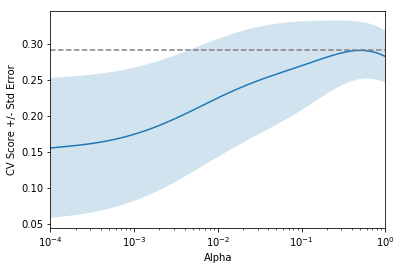

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(alpha_space, reg_scores)

std_error = reg_scores_std / np.sqrt(10)

ax.fill_between(alpha_space, reg_scores + std_error, reg_scores - std_error, alpha=0.2)
ax.set_ylabel('CV Score +/- Std Error')
ax.set_xlabel('Alpha')
ax.axhline(np.max(reg_scores), linestyle='--', color='.5')
ax.set_xlim([alpha_space[0], alpha_space[-1]])
ax.set_xscale('log')
plt.show()

It seems like $\alpha = 0.4$ gives the best cross-validated $R^2$.

---
## Using Lasso regression for feature selection

We'll see what features remain after using an out-of-the-sklearn-box Lasso regressor (no hyperparamater tuning) to find strong predictor features for `Yield Rate (all)`:

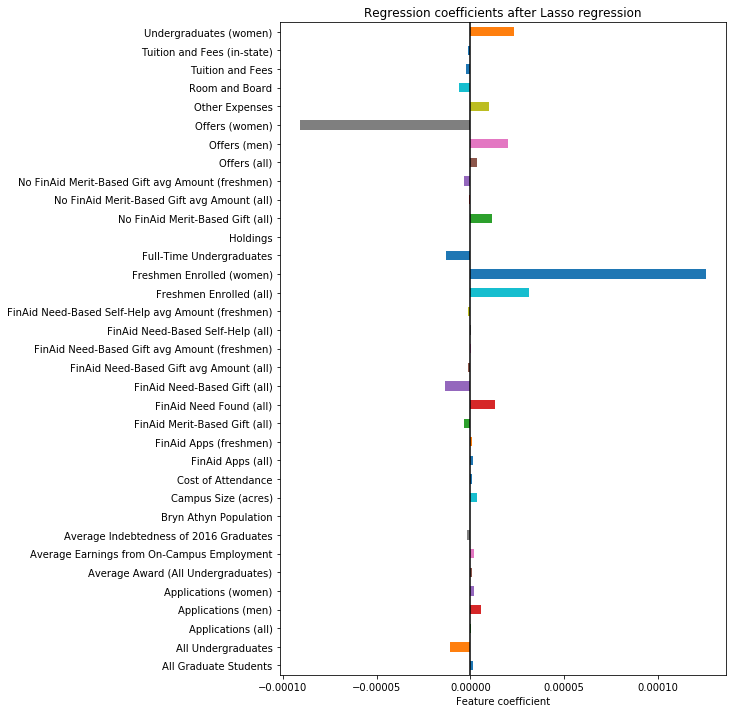

In [8]:
lassoreg = Lasso()
lassoreg.fit(X, y)
coef = pd.Series(lassoreg.coef_, index = X.columns)
coef = coef[coef != 0]  # Drop zero-valued coefs
plt.figure(figsize=(8,12))
coef.plot(kind = 'barh')
plt.axvline(0, color = 'black')
plt.title('Regression coefficients after Lasso regression')
plt.xlabel('Feature coefficient')
plt.show()

A higher `Freshmen Enrolled (women)` and lower `Offers (women)` strongly correlates with a higher `Yield Rate (all)`, which by itself isn't terribly surprising. 

What is suprising is apparently a higher `Offers (men)` somewhat correlates to a *higher* `Yield Rate (all)`, which is opposite of the trend for women.

---

## Classifying US News rank type

As an exercise, we can use the a basic k-nearest neighbors classifier to predict the US News `Rank Type`, which we'll need to first read from CSV:

In [9]:
ranks = pd.read_csv('data/joined.csv', index_col = 'SchoolId', usecols = ['SchoolId','Rank Type'])
df = df.join(ranks)

y = df['Rank Type']
X = df.drop(columns='Rank Type')

def run_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors = 5)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))
    
run_classifier(X, y)

                                precision    recall  f1-score   support

National Liberal Arts Colleges       0.34      0.60      0.43        47
         National Universities       0.67      0.64      0.65        74
     Regional Colleges Midwest       0.14      0.17      0.15        18
       Regional Colleges North       0.00      0.00      0.00         7
       Regional Colleges South       0.05      0.06      0.05        18
        Regional Colleges West       0.00      0.00      0.00         7
 Regional Universities Midwest       0.10      0.11      0.11        35
   Regional Universities North       0.17      0.14      0.16        42
   Regional Universities South       0.17      0.07      0.10        42
    Regional Universities West       0.16      0.08      0.11        36
               Unranked School       0.53      0.58      0.56        89

                   avg / total       0.34      0.35      0.34       415



Not the greatest performance, by really any measure. But is there really any difference between the schools in 'North', 'South', 'West', and 'Midwest' other than their geographic location? Let's group them all together and try again. We'll also combine the National Liberal Arts Colleges with the National Universities:

In [11]:
y = y.replace(r'Regional.*', 'Regional', regex=True)
y = y.replace(r'National.*', 'National', regex=True)

run_classifier(X, y)

                 precision    recall  f1-score   support

       National       0.66      0.61      0.63       127
       Regional       0.61      0.73      0.66       200
Unranked School       0.55      0.36      0.44        88

    avg / total       0.61      0.61      0.61       415



That's a bit better. Still not great. Let's try just trying to classify National against all others by combining Regional and Unranked School:

In [12]:
y = y.replace('Regional', 'Other')
y = y.replace('Unranked School', 'Other')

run_classifier(X, y)

             precision    recall  f1-score   support

   National       0.78      0.53      0.63       131
      Other       0.81      0.93      0.87       284

avg / total       0.80      0.80      0.79       415



Quite a bit better. Let's see how kNN compares to a simple logistic regression: 

In [13]:
y = y.replace('National', 0)
y = y.replace('Other', 1)
X_train, X_test, y_train, y_test = train_test_split(X, y)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['National','Other']))

             precision    recall  f1-score   support

   National       0.96      0.85      0.90       130
      Other       0.93      0.99      0.96       285

avg / total       0.94      0.94      0.94       415



Quite nice for a simple logistic regression, though considering we are using 136 features on only 1660 observations, this logistic regression might be overfitting.

Looking at the ROC for this logistic regression:

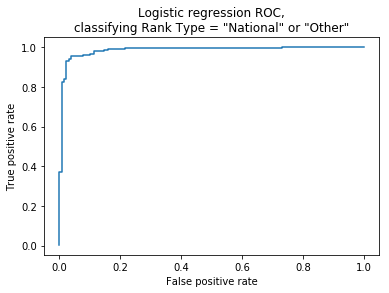

In [14]:
y_pred_proba = logreg.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba[:,1])

plt.plot(fpr, tpr)
plt.title('Logistic regression ROC,\n'
          'classifying Rank Type = "National" or "Other"')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()